In [ ]:
## ResME model to estimate methane emissions from hydropower reservoirs

## see Delwiche et al., in preparation

#Necessary input files:
# Reservoirs_table.xlsx (available on GitHub)
# Stratified reservoir temperatures available from ERA5_Land product (extracted using Google Earth Engine)
# Above and below ground carbon pools estimate, from xxxxxxx
# Annual average temperature from MERRA2 (T2M_annual.merra2.01x01.2015.nc)
# Sediment flux estimates from WBMSed, provided to us upon request from Sagy Cohen (from University of Alabama)
# POC/DOC/TOC ratio data from Meybeck, 1982 (available on GitHub)


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import cartopy  
import cartopy.crs as crs 
import matplotlib.dates as mdates
import glob
from scipy import stats
from netCDF4 import Dataset

pd.set_option('display.width', 600)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 1900)  #has to be more than the max# of rows in the dataframe, or it reverts to 10 - so silly!!


#  Load reservoir data 

In [2]:
Res_CH4  = pd.read_excel('Reservoirs_table.xlsx')

# Add values from external data sources

### ERA5 Land water temperatures

In [3]:
temps_era5 = pd.read_excel('../model inputs/Res_temp_strat_from_ERA5_Land.xlsx')
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
temps_era5.loc[:,'date'] = temps_era5.loc[:,'date'].str[0:10]
temps_era5['date'] = pd.to_datetime(temps_era5['date'], format = '%Y-%m-%d')
temps_era5['month'] = pd.DatetimeIndex(temps_era5['date']).month
temps_era5.sort_values(by=['name', 'month'], inplace = True)
temps_era5.reset_index(inplace =True, drop = True)

temps_era5_avg = temps_era5.groupby(['name','month']).mean()
temps_era5_avg.reset_index(inplace =True)

bottom_temps = temps_era5_avg.pivot(index = 'name',columns = 'month',values = 'lake_bottom_temp_mean')
bottom_temps.columns = bottom_temps.columns.astype(str)
bottom_temps.rename(columns = {'1':'Jan', '2':'Feb', '3':'Mar','4':'Apr','5':'May','6':'Jun','7':'Jul','8':'Aug','9':'Sep','10':'Oct','11':'Nov','12':'Dec'}, inplace = True)
bottom_temps.reset_index(inplace = True)
bottom_temps = bottom_temps.add_suffix('_bottom_temp')
bottom_temps.rename(columns = {'name_bottom_temp':'System'}, inplace = True)


epi_temps = temps_era5_avg.pivot(index = 'name',columns = 'month',values = 'lake_mixed_layer_temp_mean')
epi_temps.columns = epi_temps.columns.astype(str)
epi_temps.rename(columns = {'1':'Jan', '2':'Feb', '3':'Mar','4':'Apr','5':'May','6':'Jun','7':'Jul','8':'Aug','9':'Sep','10':'Oct','11':'Nov','12':'Dec'}, inplace = True)
epi_temps.reset_index(inplace = True)
epi_temps = epi_temps.add_suffix('_epi_temp')
epi_temps.rename(columns = {'name_epi_temp':'System'}, inplace = True)

Res_CH4 = pd.merge(Res_CH4, bottom_temps, on = 'System', how = 'left')
Res_CH4 = pd.merge(Res_CH4, epi_temps, on = 'System', how = 'left')

## Add average mixed layer temperature
a = temps_era5_avg.groupby(['name']).mean()
a.reset_index(inplace = True)
a.rename(columns = {'name':'System'}, inplace = True)

Res_CH4 = pd.merge(Res_CH4, a[['System','lake_mixed_layer_depth']] , on = 'System', how = 'left')



### Flooded biomass carbon loading

In [4]:
Carbon_Pools_Ann= np.load('../model inputs/Carbon_Pools_Ann.npy')   # kg/m2
Carbon_Pools_Ann = Carbon_Pools_Ann * 1000000   #mg C/m2

pools = pd.DataFrame(columns=['System','carbs','leaves','fine_roots','wood','wood_debris','surfmet','surfstruct','surfmic','soilmet','soilstruct','soilmic','soilslow','soilarm'])
for reservoir in np.arange(len(Res_CH4)):

    lati_carbonAnn = int((Res_CH4.loc[reservoir,'Latitude']+90)/float(0.5))  #0.5 here because there are 2 values per degree
    loni_carbonAnn = int((Res_CH4.loc[reservoir,'Longitude']+180)/float(0.5))

    pools.loc[reservoir,'System'] = Res_CH4.loc[reservoir,'System']
    pools.loc[reservoir,'carbs'] = Carbon_Pools_Ann[0,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'leaves'] = Carbon_Pools_Ann[1,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'fine_roots'] = Carbon_Pools_Ann[2,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'wood'] = Carbon_Pools_Ann[3,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'wood_debris'] = Carbon_Pools_Ann[4,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'surfmet'] = Carbon_Pools_Ann[5,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'surfstruct'] = Carbon_Pools_Ann[6,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'surfmic'] = Carbon_Pools_Ann[7,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'soilmet'] = Carbon_Pools_Ann[8,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'soilstruct'] = Carbon_Pools_Ann[9,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'soilmic'] = Carbon_Pools_Ann[10,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'soilslow'] = Carbon_Pools_Ann[11,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2
    pools.loc[reservoir,'soilarm'] = Carbon_Pools_Ann[12,lati_carbonAnn,loni_carbonAnn]   #now in mg/m2


pools['Biomass_nowood'] =  pools[['carbs','leaves','fine_roots', 'surfmet','surfstruct','surfmic','soilmet','soilstruct','soilmic']].sum(axis=1)

Res_CH4 = pd.merge(Res_CH4, pools[['System','Biomass_nowood']])

### Average annual air temperature from MERRA2

In [5]:
Res_CH4['Temp'] = 0.0

are_f = Dataset('../model inputs/Temperature_Data/T2M_annual.merra2.01x01.2015.nc')
Temp_All = np.array(are_f.variables['GMAO_2D__T2M'])[0,:,:]   #181 rows, 361 columns  

for reservoir in np.arange(len(Res_CH4)):

    Lati = int((Res_CH4.loc[reservoir,'Latitude']+90))
    Loni = int((Res_CH4.loc[reservoir,'Longitude']+180))

    Res_CH4.loc[reservoir,'Temp'] = Temp_All[int(Lati/0.1),int(Loni/0.1)]  #need to divide by 0.1 here beause Temp_All is 10 times as big as other arrays!


### Add incoming sediment transport from WBMSed output

In [6]:
years = ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2015','2016','2017','2018','2019']

data_mat = np.zeros((len(years), 1500, 3600))
discharge_mat = np.zeros((len(years), 1500, 3600))
for count, iyear in enumerate(years):

    filename = glob.glob('../model inputs/WBMSed/SedFlux/Global_SedimentFlux' + '*' + iyear + '*')    #WBMSed model results provided by Sagy Cohen (from University of Alabama) upon request
    filename_discharge = glob.glob('../model inputs/WBMSed/Discharge/Global_Discharge' + '*' + iyear + '*')   #WBMSed model results provided by Sagy Cohen (from University of Alabama) upon request
    data = Dataset(filename[0])
    data_discharge = Dataset(filename_discharge[0])

    sed_flux= np.array(data.variables['SedimentFlux'])[:]
    discharge = np.array(data_discharge.variables['discharge'][:])

    data_mat[count,:,:] = sed_flux[0,:,:]
    discharge_mat[count,:,:] = discharge[0,:,:]
    
    data_mat[data_mat == 0] = np.nan
    data_mat[data_mat < 0] = np.nan
    
    discharge_mat[discharge_mat == 0] = np.nan  # probably not necessary any more - set zeros to nan so they don't get included in average later on
    discharge_mat[discharge_mat < 0] = np.nan
    
sed_flux_mean = np.nanmean(data_mat, axis=0)
sed_flux_std = np.nanstd(data_mat, axis=0)

discharge_mean = np.nanmean(discharge_mat, axis=0)
discharge_std = np.nanstd(discharge_mat, axis=0)

np.save('data_mat', data_mat)
np.save('discharge_mat', discharge_mat)



C:\Users\Owner\AppData\Local\Temp/ipykernel_21360/43107110.py:24: RuntimeWarning: Mean of empty slice
  sed_flux_mean = np.nanmean(data_mat, axis=0)
C:\Users\Owner\Anaconda3\envs\InterannualAnalysis\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Owner\AppData\Local\Temp/ipykernel_21360/43107110.py:27: RuntimeWarning: Mean of empty slice
  discharge_mean = np.nanmean(discharge_mat, axis=0)


In [7]:
for reservoir in np.arange(len(Res_CH4)):
    
    #start by estimating TSS concentration in river
    Lati = int((round(Res_CH4.loc[reservoir,'Latitude'],1)+60 )*10) #plus 60 here because latitudes go down to -60, round to 0.1 place bc that's the resolution of the data, *10 to get to integer
    Loni = int((round(Res_CH4.loc[reservoir,'Longitude'],1)+180)*10)
    
    n = 5  # number of pixels to average in each direction

    sed_transport = data_mat[:,(Lati-n):(Lati + n+1),(Loni-n):(Loni+n+1) ]  #sediment flux for all years, just the n pixels surrounding the lat/lon
    discharge = discharge_mat[:,(Lati-n):(Lati + n+1),(Loni-n):(Loni+n+1) ] #all years, just the n pixels surrounding the lat/lon
    discharge_sum_arr = np.nansum(np.nansum(discharge, axis=1), axis=1)  # discharge sum per pixel grouping per year
    discharge_weighted = discharge / discharge_sum_arr[:,None,None]  #not 100% sure this works: https://stackoverflow.com/questions/19602187/numpy-divide-each-row-by-a-vector-element

    annual_sed_flux = sed_transport * discharge_weighted  # first multiply the data by the weights for each year

    a = np.nansum(annual_sed_flux, axis = 1)

    annual_sed_flux = np.nansum(np.nansum(annual_sed_flux, axis = 1), axis = 1)  #then calculate annual sed_flux number (this line sums the weighted sediment flux across the n x n pixels in each of the 18 years)

    Res_CH4.loc[reservoir,'TSS_wbmsed_avg'] = np.nanmean(annual_sed_flux)  #this is in kg/s
    Res_CH4.loc[reservoir,'TSS_wbmsed_std'] = np.nanstd(annual_sed_flux)
  
    concentration = sed_transport/discharge * 1e6 / 1000 #in mg/L  sediment concentration in each pixel
    concentration_weighted_mean = concentration * discharge_weighted
    Qs_mgL = np.nansum(np.nansum(concentration_weighted_mean, axis = 1), axis = 1).mean()
    Res_CH4.loc[reservoir,'Qs_mgL'] = Qs_mgL

## Estimate littoral area percentage

In [8]:
Res_CH4['bath_shape'] = Res_CH4.DAM_HGT_M/Res_CH4.Mean_Depth_m - 1   #method from G-res technical documentation, https://www.hydropower.org/publications/the-ghg-reservoir-tool-g-res-technical-documentation
Res_CH4['littoral_area'] = (1 - (1 - 3/Res_CH4['DAM_HGT_M'])**Res_CH4['bath_shape'])*100   #method from G-res technical documentation, https://www.hydropower.org/publications/the-ghg-reservoir-tool-g-res-technical-documentation
Res_CH4['littoral_area'].fillna(50, inplace = True)


# Carbon input estimates

### Estimate primary production based on trophic status

In [9]:
#Estimate primary production using trophic status from Deemer paper and my background research
Res_CH4['Primary_Prod'] = 0.0

primeprod = np.array([150, 0.5*(150+600), 600, 0.5*(600 + 2000), 2000]) #based on reservoir values in Table 15-12 of Wetzel:

Res_CH4.loc[Res_CH4.Trophic_Status == 'Oligotrophic', 'Primary_Prod'] = primeprod[0]   # mg C / m2/day
Res_CH4.loc[Res_CH4.Trophic_Status == 'Oligo_Meso', 'Primary_Prod'] = primeprod[1]   # mg C / m2/day
Res_CH4.loc[Res_CH4.Trophic_Status == 'Mesotrophic', 'Primary_Prod'] = primeprod[2]   # mg C / m2/day
Res_CH4.loc[Res_CH4.Trophic_Status == 'Meso_Eutrophic', 'Primary_Prod'] = primeprod[3]   # mg C / m2/day
Res_CH4.loc[Res_CH4.Trophic_Status == 'Eutrophic', 'Primary_Prod'] = primeprod[4]   # mg C / m2/day
                  

### Estimate POC and DOC rates based on Meybeck data

#### Define function to estimate POC as fraction of suspended sediment matter

C:\Users\Owner\Anaconda3\envs\InterannualAnalysis\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


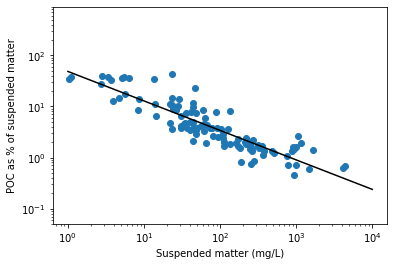

In [10]:
POC_meybeck = pd.read_excel('../model inputs/Meybeck_loadings.xlsx',sheet_name = 'Fig1')
# DOC_to_TOC_meybeck = pd.read_excel('../model inputs/Meybeck_loadings.xlsx',sheet_name = 'Fig2')

plt.scatter(POC_meybeck.Suspended_matter_mg_l, POC_meybeck.POC_perc)
plt.ylabel('POC as % of suspended matter')
plt.xlabel('Suspended matter (mg/L)')
plt.semilogx()
plt.semilogy()

# define equation to estimate % POC of total suspended matter
log_suspended_matter = np.log(POC_meybeck.Suspended_matter_mg_l)  #x value
log_POC_perc = np.log(POC_meybeck.POC_perc)  #y value
log_suspended_matter = sm.add_constant(log_suspended_matter)  #add a constant intercept so I am not forcing through 0,0
model1 = sm.OLS(log_POC_perc,  log_suspended_matter, hasconstant = True).fit()   #(y,x)
y1 = model1.params

def poc_perc(x):
    y = np.exp(y1[0])*np.exp(y1[1]*np.log(x))
    if y > 50:
        y = 50
    
    return y


x = np.arange(1, 10000)
plt.ylim(0.05, 900)
plt.plot(x,np.exp(y1[0])*np.exp(y1[1]*np.log(x)), 'k')


#### Define function to estimate DOC as a fraction of TOC

C:\Users\Owner\Anaconda3\envs\InterannualAnalysis\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


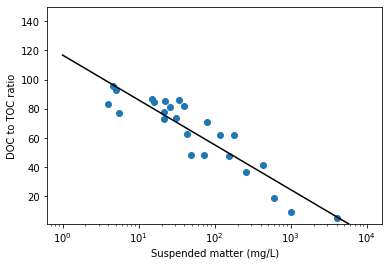

In [11]:
DOC_to_TOC_meybeck = pd.read_excel('../model inputs/Meybeck_loadings.xlsx',sheet_name = 'Fig2')
DOC_to_TOC_meybeck.head(3)

plt.scatter(DOC_to_TOC_meybeck.Suspended_matter_mg_l, DOC_to_TOC_meybeck.DOC_to_TOC_perc)
plt.ylabel('DOC to TOC ratio')
plt.xlabel('Suspended matter (mg/L)')
plt.semilogx()


# define equation to estimate % POC of total suspended matter
log_suspended_matter = np.log(DOC_to_TOC_meybeck.Suspended_matter_mg_l)  #x value
log_DOC_to_TOC = DOC_to_TOC_meybeck.DOC_to_TOC_perc  #y value
log_suspended_matter = sm.add_constant(log_suspended_matter)  #add a constant intercept so I am not forcing through 0,0
model2 = sm.OLS(log_DOC_to_TOC,  log_suspended_matter, hasconstant = True).fit()   #(y,x)
y2 = model2.params

def doc_to_toc_perc(x):

    y = np.log(x)*y2[1] + y2[0]
    
    #set upper and lower bounds
    if y > 95:   #fraction of DOC to TOC cannot exceed 1, default to 0.95 so there is always at least a small amt of DOC entering  
        y = 95
    if y < 5:
        y = 5
    return y

x = np.arange(1, 10000)
plt.ylim(1, 150)
plt.plot(x,np.log(x)*y2[1] + y2[0], 'k')


### Calculate allochthonous POC and DOC inputs

In [12]:

#Estimate temperature-dependent flocculation rate.

temps = [4, 10, 20]
floc_rate = np.array([3.4, 8.8, 11.0])/25/1000  #flocculation rate in ratio lost per day (x100 for % lost per day) (Table 2 in Wachenfeldt), 25mg/L is ~ starting DOC value
slope, intercept, r_value, p_value, std_err = stats.linregress(temps,floc_rate)


for reservoir in np.arange(len(Res_CH4)):
    

    Lati = int((round(Res_CH4.loc[reservoir,'Latitude'],1)+60 )*10) #plus 60 here because latitudes go down to -60, round to 0.1 place bc that's the resolution of the data, *10 to get to integer
    Loni = int((round(Res_CH4.loc[reservoir,'Longitude'],1)+180)*10)
       
    Qs_mgL = Res_CH4.loc[reservoir,'Qs_mgL']  #value from WBMSed results
    
    
    Res_CH4.loc[reservoir,'ALLOC_POC'] = poc_perc(Qs_mgL)/100 * Qs_mgL * 1000 * Res_CH4.loc[reservoir,'Volume_km3'] * 1000**3 /  (Res_CH4.loc[reservoir,'Residence_Time_days']/365 ) / (Res_CH4.loc[reservoir,'Surface_Area_km2'] * 1000**2) 
    Res_CH4.loc[reservoir,'ALLOC_DOC'] = doc_to_toc_perc(Qs_mgL)/100 * Res_CH4.loc[reservoir,'ALLOC_POC'] / (1-doc_to_toc_perc(Qs_mgL)/100)  #mg/m2/year
    Res_CH4.loc[reservoir,'ALLOC_POC_inflow_mg_l'] = Res_CH4.loc[reservoir, 'Qs_mgL']* poc_perc(Res_CH4.loc[reservoir, 'Qs_mgL'])/100   #    
    
    
    #Now estimate DOC transport to sediment via flocculation

    Res_CH4.loc[reservoir,'flocc_rate'] = slope*(Res_CH4.loc[reservoir,'Temp']-273) + intercept   #daily flocculation rate, slope, intercept determined in cell above
    Res_CH4.loc[reservoir,'ALLOC_DOC'] = Res_CH4.loc[reservoir,'ALLOC_DOC'] * (Res_CH4.loc[reservoir,'flocc_rate']*365) #mg/m2/year
    
    #we can estimate trapping efficiency for reservoirs larger than 0.5 km3, see Vorosmarty et al.
    Res_CH4.loc[reservoir,'Trap_eff'] = 0.3  #30% global estimate is also from Vorosmarty
    
    if Res_CH4.loc[reservoir,'Volume_km3'] > 0.5:
        Res_CH4.loc[reservoir,'Trap_eff'] = 1-(0.05/((Res_CH4.loc[reservoir,'Residence_Time_days']/365)**0.5))


Res_CH4['ALLOC_DOC'] = Res_CH4['ALLOC_DOC'] * Res_CH4['Trap_eff']/365  #convert from years to days, result in mg/m2/day
Res_CH4['ALLOC_POC'] = Res_CH4['ALLOC_POC'] * Res_CH4['Trap_eff']/365 #mg/m2/day


In [13]:
# Res_CH4.to_pickle('ResME_input.pickle')


# Run ResME to estimate total methane production from each carbon type

In [14]:
methane_factor = 0.5   #fraction of carbon decayed to methane vs CO2


# Parameters extracted based on data in Grasset et al., 2018 "Large but variable methane production in anoxic freshwater sediment upon addition of allochthonous and autochthonous organic matter"
alpha_auto = 0.61961095
v_auto = 0.460240

v_bio = 0.15232051
alpha_bio =  0.9171205516

v_alloc = v_bio
alpha_alloc = alpha_bio


#initialize arrays used in model
monthly_C_Auto_decay_epi = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
monthly_C_Auto_decay_hypo = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

monthly_C_Alloc_DOC_decay_epi =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
monthly_C_Alloc_DOC_decay_hypo = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

monthly_C_Alloc_POC_decay_epi = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
monthly_C_Alloc_POC_decay_hypo = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

monthly_C_Bio_decay_epi = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
monthly_C_Bio_decay_hypo = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

monthly_auto_all =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
monthly_alloc_DOC_all =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
monthly_alloc_POC_all =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
monthly_bio_all =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#**********   MODEL CALCULATIONS   **************************************************************

for ires in np.arange(len(Res_CH4)): 

    numyears = round(Res_CH4.loc[ires,'Age_yrs'])
    system = Res_CH4.loc[ires,'System']
    months = int(numyears*12)                                   #pull out reservoir age
    print(system)   

    #****************Initialize arrays used for each reservoir************************************************
    
    Yearly_Auto_decay_epi = np.zeros(int(numyears))    
    Yearly_Auto_decay_hypo = np.zeros(int(numyears))   
    Yearly_Alloc_DOC_decay_epi = np.zeros(int(numyears))    
    Yearly_Alloc_DOC_decay_hypo = np.zeros(int(numyears))   
    Yearly_Alloc_POC_decay_epi = np.zeros(int(numyears))    
    Yearly_Alloc_POC_decay_hypo = np.zeros(int(numyears))   
    Yearly_Bio_decay_epi = np.zeros(int(numyears))    
    Yearly_Bio_decay_hypo = np.zeros(int(numyears))   

    C_Auto_stock_epi = np.zeros(months + 1)
    C_Auto_decay_epi = np.zeros(12)   
    C_Auto_stock_hypo = np.zeros(months + 1)
    C_Auto_decay_hypo = np.zeros(12) 
    
    C_Alloc_DOC_stock_epi = np.zeros(months + 1)
    C_Alloc_DOC_decay_epi = np.zeros(12)   
    C_Alloc_DOC_stock_hypo = np.zeros(months + 1)
    C_Alloc_DOC_decay_hypo = np.zeros(12) 
    
    C_Alloc_POC_stock_epi = np.zeros(months + 1)
    C_Alloc_POC_decay_epi = np.zeros(12)   
    C_Alloc_POC_stock_hypo = np.zeros(months + 1)
    C_Alloc_POC_decay_hypo = np.zeros(12) 
    
    C_Bio_stock_epi = np.zeros(months + 1)
    C_Bio_decay_epi = np.zeros(12)    
    C_Bio_stock_hypo = np.zeros(months + 1)
    C_Bio_decay_hypo = np.zeros(12)       

    #************** Calculate decay parameters for each month and each carbon type****************************
    
    k_auto_vec = v_auto/(alpha_auto + np.arange(months+1))  #create vector of decay rate for carbon of every age
    k_alloc_vec = v_alloc/(alpha_alloc + np.arange(months+1))  #create vector of decay rate for carbon of every age 
    k_bio_vec = v_bio/(alpha_bio + np.arange(months+1))  #create vector of decay rate for carbon of every age 


    #************** Extract monthly carbon loading for allochthonous and autochthonous carbon, and single-time loading for flooded biomass *****************
    
    Auto_loading = Res_CH4.loc[ires,'Primary_Prod'] * (365/12)  #mgC/m2/month       
    Auto_loading = 0.4 * Auto_loading                           #assume 30% of primary production reaches sediment 
      
    Alloc_DOC_loading = Res_CH4.loc[ires,'ALLOC_DOC']  * (365/12)  #mgC/m2/month
    Alloc_POC_loading = Res_CH4.loc[ires,'ALLOC_POC']  * (365/12)  #mgC/m2/month
    Biomass_loading = Res_CH4.loc[ires,'Biomass_nowood']           #mgC/m2

    
    C_Bio_stock_epi[0] = Biomass_loading
    C_Bio_stock_hypo[0] = Biomass_loading

#**********************************************************************************

    #initialize place-keeping variables
    check_month = 0     #start off in month 0, January
    year_counter = 0  #keep track of which year we are in, start off at 1 so break statement below works

    month_mapping = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    
    for imonth in np.arange(12*numyears):
        
        #********************** Get water temperatures*****************
        month = month_mapping[check_month]
        temp_epi = Res_CH4.loc[ires,month + '_epi_temp'] - 273       #Celsius
        temp_hypo = Res_CH4.loc[ires,month + '_bottom_temp'] - 273   #Celsius

      #************ First calculate monthly decay*********************
       
        C_Auto_decay_epi[check_month] = sum(C_Auto_stock_epi*k_auto_vec*1.07**(int(temp_epi)-20))                #mg C/m2/day 
        C_Auto_decay_hypo[check_month] = sum(C_Auto_stock_hypo*k_auto_vec*1.07**(int(temp_hypo)-20))             #mg C/m2/day 
        C_Alloc_DOC_decay_epi[check_month] = sum(C_Alloc_DOC_stock_epi*k_alloc_vec*1.07**(int(temp_epi)-20))     #mg C/m2/day 
        C_Alloc_DOC_decay_hypo[check_month] = sum(C_Alloc_DOC_stock_hypo*k_alloc_vec*1.07**(int(temp_hypo)-20))  #mg C/m2/day 
        C_Alloc_POC_decay_epi[check_month] = sum(C_Alloc_POC_stock_epi*k_alloc_vec*1.07**(int(temp_epi)-20))     #mg C/m2/day 
        C_Alloc_POC_decay_hypo[check_month] = sum(C_Alloc_POC_stock_hypo*k_alloc_vec*1.07**(int(temp_hypo)-20))  #mg C/m2/day 
        C_Bio_decay_epi[check_month] = sum(C_Bio_stock_epi*k_bio_vec*1.07**(int(temp_epi)-20))                   #mg C/m2/day 
        C_Bio_decay_hypo[check_month] = sum(C_Bio_stock_hypo*k_bio_vec*1.07**(int(temp_hypo)-20))                #mg C/m2/day 
        

     #************ Then update vector for following month***************


        C_Auto_stock_epi = C_Auto_stock_epi - C_Auto_stock_epi*k_auto_vec*1.07**(int(temp_epi)-20)       #mg C/m2/day 
        C_Auto_stock_epi = np.roll(C_Auto_stock_epi, 1)
        C_Auto_stock_epi[0] = Auto_loading   #New carbon input every month, mg C/m2/day 
        C_Auto_stock_hypo = C_Auto_stock_hypo - C_Auto_stock_hypo*k_auto_vec*1.07**(int(temp_hypo)-20)   #mg C/m2/day 
        C_Auto_stock_hypo = np.roll(C_Auto_stock_hypo, 1)
        C_Auto_stock_hypo[0] = Auto_loading   #New carbon input every month, mg C/m2/day 
        
        C_Alloc_DOC_stock_epi = C_Alloc_DOC_stock_epi - C_Alloc_DOC_stock_epi*k_alloc_vec*1.07**(int(temp_epi)-20)       #mg C/m2/day 
        C_Alloc_DOC_stock_epi = np.roll(C_Alloc_DOC_stock_epi, 1)
        C_Alloc_DOC_stock_epi[0] = Alloc_DOC_loading     #New carbon input every month, mg C/m2/day 
        C_Alloc_DOC_stock_hypo = C_Alloc_DOC_stock_hypo - C_Alloc_DOC_stock_hypo*k_alloc_vec*1.07**(int(temp_hypo)-20)   #mg C/m2/day 
        C_Alloc_DOC_stock_hypo = np.roll(C_Alloc_DOC_stock_hypo, 1)
        C_Alloc_DOC_stock_hypo[0] = Alloc_DOC_loading     #New carbon input every month, mg C/m2/day 
        
        C_Alloc_POC_stock_epi = C_Alloc_POC_stock_epi - C_Alloc_POC_stock_epi*k_alloc_vec*1.07**(int(temp_epi)-20)       #mg C/m2/day 
        C_Alloc_POC_stock_epi = np.roll(C_Alloc_POC_stock_epi, 1)
        C_Alloc_POC_stock_epi[0] = Alloc_POC_loading   #New carbon input every month, mg C/m2/day 
        C_Alloc_POC_stock_hypo = C_Alloc_POC_stock_hypo - C_Alloc_POC_stock_hypo*k_alloc_vec*1.07**(int(temp_hypo)-20)   #mg C/m2/day 
        C_Alloc_POC_stock_hypo = np.roll(C_Alloc_POC_stock_hypo, 1)
        C_Alloc_POC_stock_hypo[0] = Alloc_POC_loading   #New carbon input every month, mg C/m2/day  
          
        C_Bio_stock_epi = C_Bio_stock_epi - C_Bio_stock_epi*k_bio_vec*1.07**(int(temp_epi)-20)       #mg C/m2/day
        C_Bio_stock_epi = np.roll(C_Bio_stock_epi, 1)
        C_Bio_stock_epi[0] = 0   #no additional loading after month 1!
        C_Bio_stock_hypo = C_Bio_stock_hypo - C_Bio_stock_hypo*k_bio_vec*1.07**(int(temp_hypo)-20)   #mg C/m2/day 
        C_Bio_stock_hypo = np.roll(C_Bio_stock_hypo, 1)
        C_Bio_stock_hypo[0] = 0   #no additional loading after month 1!


        check_month += 1   #increment month counter by one (keeping track of month within each year)

     #************ sum carbon over all carbon age pools to get a total carbon value per year of reservoir life***************

        if check_month == 12:   #have reached end of year
            Yearly_Auto_decay_epi[year_counter] = sum(C_Auto_decay_epi)  #mg C/m2/year
            Yearly_Auto_decay_hypo[year_counter] = sum(C_Auto_decay_hypo)  #mg C/m2/year
            Yearly_Alloc_DOC_decay_epi[year_counter] = sum(C_Alloc_DOC_decay_epi)  #mg C/m2/year
            Yearly_Alloc_DOC_decay_hypo[year_counter] = sum(C_Alloc_DOC_decay_hypo)  #mg C/m2/year
            Yearly_Alloc_POC_decay_epi[year_counter] = sum(C_Alloc_POC_decay_epi)  #mg C/m2/year
            Yearly_Alloc_POC_decay_hypo[year_counter] = sum(C_Alloc_POC_decay_hypo)  #mg C/m2/year
            Yearly_Bio_decay_epi[year_counter] = sum(C_Bio_decay_epi)  #mg C/m2/year
            Yearly_Bio_decay_hypo[year_counter] = sum(C_Bio_decay_hypo)  #mg C/m2/year

            check_month = 0  #reset to zero because we are starting new month
           
            #save these values to use after loop
            C_Auto_decay_epi_archive =  C_Auto_decay_epi   #mg C/m2/month
            C_Auto_decay_hypo_archive = C_Auto_decay_hypo  
            C_Alloc_DOC_decay_epi_archive = C_Alloc_DOC_decay_epi   
            C_Alloc_DOC_decay_hypo_archive = C_Alloc_DOC_decay_hypo   
            C_Alloc_POC_decay_epi_archive = C_Alloc_POC_decay_epi 
            C_Alloc_POC_decay_hypo_archive = C_Alloc_POC_decay_hypo 
            C_Bio_decay_epi_archive = C_Bio_decay_epi 
            C_Bio_decay_hypo_archive = C_Bio_decay_hypo 
            
            #reset these to zero
            C_Auto_decay_epi = np.zeros(12)   
            C_Auto_decay_hypo = np.zeros(12)   
            C_Alloc_DOC_decay_epi = np.zeros(12)  
            C_Alloc_DOC_decay_hypo = np.zeros(12)  
            C_Alloc_POC_decay_epi = np.zeros(12)  
            C_Alloc_POC_decay_hypo = np.zeros(12)  
            C_Bio_decay_epi = np.zeros(12)  
            C_Bio_decay_hypo = np.zeros(12)  
            
                        
            year_counter += 1

  
    #***************Finished looping through all months**************************************
    #***Now calculate methane production in most recent year*********************************
    
    
    epi_area_param = Res_CH4.loc[ires,'SA_epi_frac']
    if epi_area_param == 0.0:
        epi_area_param = Res_CH4.loc[ires,'littoral_area']/100
    hypo_area_param = 1 - epi_area_param 
    
    
    #*************** calculate total DAILY methane production********************************
    Total_prod_alloc_DOC = methane_factor *(epi_area_param *Yearly_Alloc_DOC_decay_epi[-1]/365 \
                                                                            + hypo_area_param * Yearly_Alloc_DOC_decay_hypo[-1]/365)  # mg/m2/day  
    Total_prod_alloc_POC = methane_factor *(epi_area_param *Yearly_Alloc_POC_decay_epi[-1]/365 \
                                                                            + hypo_area_param * Yearly_Alloc_POC_decay_hypo[-1]/365)  # mg/m2/day
    Total_prod_auto = methane_factor *(epi_area_param *Yearly_Auto_decay_epi[-1]/365 \
                                                                            + hypo_area_param * Yearly_Auto_decay_hypo[-1]/365)       # mg/m2/day
    Total_prod_bio = methane_factor *(epi_area_param *Yearly_Bio_decay_epi[-1]/365 \
                                                                            + hypo_area_param * Yearly_Bio_decay_hypo[-1]/365)        # mg/m2/day
    
    
    Res_CH4.loc[ires,'Auto_flux'] = Total_prod_auto           # mg/m2/day 
    Res_CH4.loc[ires,'Alloc_DOC_flux'] = Total_prod_alloc_DOC # mg/m2/day 
    Res_CH4.loc[ires,'Alloc_POC_flux'] = Total_prod_alloc_POC # mg/m2/day 
    Res_CH4.loc[ires,'Biomass_flux'] = Total_prod_bio         # mg/m2/day 

    #********************* save the monthly output for the final year ********************************   
    monthly_auto = methane_factor *(epi_area_param *C_Auto_decay_epi_archive + hypo_area_param * C_Auto_decay_hypo_archive)                #mg C/m2/month
    monthly_alloc_POC = methane_factor *(epi_area_param *C_Alloc_POC_decay_epi_archive + hypo_area_param * C_Alloc_POC_decay_hypo_archive) #mg C/m2/month
    monthly_alloc_DOC = methane_factor *(epi_area_param *C_Alloc_DOC_decay_epi_archive + hypo_area_param * C_Alloc_DOC_decay_hypo_archive) #mg C/m2/month 
    monthly_bio = methane_factor *(epi_area_param *C_Bio_decay_epi_archive + hypo_area_param * C_Bio_decay_hypo_archive)                   #mg C/m2/month
    
    #*********************** combine monthly outputs from each reservoir********************************
    monthly_auto_all = np.vstack((monthly_auto_all, monthly_auto))                 #mg C/m2
    monthly_alloc_POC_all = np.vstack((monthly_alloc_POC_all, monthly_alloc_POC))  #mg C/m2
    monthly_alloc_DOC_all = np.vstack((monthly_alloc_DOC_all, monthly_alloc_DOC))  #mg C/m2
    monthly_bio_all = np.vstack((monthly_bio_all, monthly_bio))                    #mg C/m2
          
    

Allatoona
Balbina
Barra Bonita
Batang Ai
Cahora Bassa
Capivari
Cle Elum
Corumba
Cos
Curua-Una
Douglas
Eastmain 1
Eguzon
Fontana
Foster
Funil
Furnas
Gatun
Grandes Patures
Grangent
Guntersville
Hartwell
Itaipu
Itaparica
Itumbiara
JC Boyle
Kariba
Laforge-1
Lokka
Lower Monumental
Manso
Maury
Miranda
Nam Leuk
Nam Ngum
Nam Theun 2
Nielisz
Pampulha
Passouira
Petit Saut
Polyfytos
Priest Rapids
Quinson
Robert-Bourassa (La Grande-2)
Saint Egreve
Segredo
Serra da Mesa
Trablettes
Tres Marias
Tucurui
Villefranche
Watts Bar
Wohlen
Xingo


## Calculate ebullition and diffusion from model results

In [15]:
base_diff = 0.5   #this could change...
max_diff = 0.3

for reservoir in np.arange(len(Res_CH4)):

    if Res_CH4.loc[reservoir,'Mean_Depth_m']< 60:   #approx depth where all bubbles dissolve
        Res_CH4.loc[reservoir,'fd'] = max_diff* (Res_CH4.loc[reservoir,'Mean_Depth_m']/60)  #I could define a maximum based on the depth at which all bubbles are expected to dissolve...
    else:
        Res_CH4.loc[reservoir,'fd'] = max_diff#  Maximum (arbitrarily chosen, can I justify this?)

#see manuscript for equation, all values in mgC/m2/day
Res_CH4['Eb_plus_Diff_all'] = (Res_CH4['Auto_flux'] + Res_CH4['Biomass_flux'] + Res_CH4['Alloc_POC_flux'] + Res_CH4['Alloc_DOC_flux'])/1.16 * (1-(base_diff+Res_CH4['fd']))


## Estimate dam emissions

In [16]:
#********************* reformat monthly CH4 production***************
all_monthly = monthly_alloc_DOC_all + monthly_alloc_POC_all + monthly_bio_all + monthly_auto_all
all_monthly = pd.DataFrame(all_monthly , columns = ['jan','feb','march','april','may','jun','jul','aug','sep','oct','nov','dec'])
all_monthly = all_monthly.drop([0])
all_monthly.reset_index(inplace = True, drop = True)
all_monthly['System'] = Res_CH4['System']  
all_monthly = all_monthly[ ['System'] + [ col for col in all_monthly.columns if col != 'System' ] ]  #move System column to front


#******************** convert CH4 production estimate to estimated dam emissions***************************
all_monthly_dam = all_monthly.copy()
all_monthly_dam.iloc[:,1:] = all_monthly_dam.iloc[:,1:].multiply((Res_CH4.loc[:, 'fd']+ 0.5), axis="index")# * (base_diff + Res_CH4['fd'])

#_________________________________________________________________________________
## Now create 2 estimates.  One dam estimate if reservoir were stratified the entire year, one if reservoir were stratified 5 months (surrounding the peak production month)

#*********** Estimate maximum dam emissions assuming year-round stratification*********************
all_monthly_dam['Annual_max'] = all_monthly_dam.iloc[:, 1:].sum(axis=1)


#*********** Estimate dam emissions for the 5 months surrounding peak water temperature*********
all_monthly_dam['Max_month'] = all_monthly_dam.iloc[:,1:-1].idxmax(axis = 1)   #get column ID for month of maximum dam emissions (which should will coincide with maximum temperature)

for irow in np.arange(len(all_monthly_dam)):

    max_col = (all_monthly_dam.loc[irow,'Max_month'])
    idx = all_monthly_dam.columns.get_loc(max_col)
    if (idx > 2) & (idx < 11): #if maximum month is between march and oct, summation is easy:
        all_monthly_dam.loc[irow,'5month_max'] = all_monthly_dam.iloc[irow,idx-2:idx+3].sum()  #This includes 2 months before and after the "idx" month of maximum CH4 production
        
    #special cases summation (wrapping months)
    if idx == 1:  # month of January
        all_monthly_dam.loc[irow,'5month_max'] = all_monthly_dam.loc[irow,['nov','dec','jan','feb','march']].sum() #mg C/m2/year
    if idx == 2:  # month of February
        all_monthly_dam.loc[irow,'5month_max'] = all_monthly_dam.loc[irow,['dec','jan','feb','march','april']].sum() #mg C/m2/year
    if idx == 11:  # month of March
        all_monthly_dam.loc[irow,'5month_max'] = all_monthly_dam.loc[irow,['sep','oct','nov','dec','jan']].sum() #mg C/m2/year
    if idx == 12:  # month of April
        all_monthly_dam.loc[irow,'5month_max'] = all_monthly_dam.loc[irow,['oct','nov','dec','jan','feb']].sum() #mg C/m2/year


all_monthly_dam['total_annual_Gg_yr'] = all_monthly_dam['Annual_max'] * Res_CH4['Surface_Area_km2'] * 1e6 * 1e-12
all_monthly_dam['5month_max_Gg_yr'] = all_monthly_dam['5month_max'] * Res_CH4['Surface_Area_km2'] * 1e6 * 1e-12
all_monthly_dam.head(2)

,System,jan,feb,march,april,may,jun,jul,aug,sep,oct,nov,dec,Annual_max,Max_month,5month_max,total_annual_Gg_yr,5month_max_Gg_yr
0,Allatoona,1734.696416,1905.131055,2368.541935,3168.168554,3635.926666,4205.157421,4280.862141,4205.982878,3940.947260,3533.969318,2446.38469,1925.051983,37350.820317,jul,20268.876366,1.830190,0.993175
1,Balbina,1816.697061,1870.046292,1886.775410,1894.744990,1899.257427,1902.066670,1903.919083,2019.233381,2110.346273,2035.326592,2012.53311,1870.107028,23221.053318,sep,10081.358439,41.101264,17.844004


## Compare ResME estimates with field measurements

C:\Users\Owner\Anaconda3\envs\InterannualAnalysis\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     mg CH4-C m-2 d-1 Diffusive + Ebullitive   R-squared:                       0.393
Model:                                                 OLS   Adj. R-squared:                  0.382
Method:                                      Least Squares   F-statistic:                     33.72
Date:                                     Fri, 11 Mar 2022   Prob (F-statistic):           3.88e-07
Time:                                             09:38:01   Log-Likelihood:                -93.318
No. Observations:                                       54   AIC:                             190.6
Df Residuals:                                           52   BIC:                             194.6
Df Model:                                                1                                         
Covariance Type:                                 nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1975      0.833     -1.438      0.156      -2.868       0.473
Eb_plus_Diff_all     0.9553      0.165      5.807      0.000       0.625       1.285
==============================================================================
Omnibus:                        3.276   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.194   Jarque-Bera (JB):                1.961
Skew:                          -0.222   Prob(JB):                        0.375
Kurtosis:                       2.179   Cond. No.                         23.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

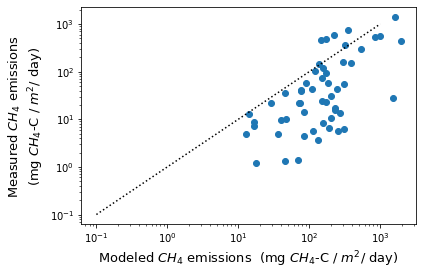

In [17]:
fig = plt.figure()
ax = plt.gca()
sc = ax.scatter(Res_CH4['Eb_plus_Diff_all'], Res_CH4['mg CH4-C m-2 d-1 Diffusive + Ebullitive'])#, cmap = 'Accent')
plt.xlabel('Modeled $CH_4$ emissions  (mg $CH_4$-C / $m^2$/ day)', fontsize = 13)
plt.ylabel('Measured $CH_4$ emissions \n(mg $CH_4$-C / $m^2$/ day)', fontsize = 13)
ax.set_yscale('log')
ax.set_xscale('log')
plt.plot([0.1,1000],[0.1,1000],':k')

log_tot_ebdiff = np.log(Res_CH4['Eb_plus_Diff_all'])
log_fielddata_tot = np.log(Res_CH4['mg CH4-C m-2 d-1 Diffusive + Ebullitive'])
log_tot_ebdiff= sm.add_constant(log_tot_ebdiff)  #add a constant intercept so I am not forcing through 0,0
model2 = sm.OLS(log_fielddata_tot,  log_tot_ebdiff, hasconstant = True).fit()   #(y,x)
test = model2.outlier_test()


model2.summary()


pred = np.log(Res_CH4['Eb_plus_Diff_all'])
val = np.log(Res_CH4['mg CH4-C m-2 d-1 Diffusive + Ebullitive'])

RMSE_all = np.sqrt( ( np.sum( (val - pred)**2)  )   / len(Res_CH4)    ) #can also calculate w mean_squared_error(y_true, y_pred)
norm_bias = np.sum(Res_CH4['Eb_plus_Diff_all'] - Res_CH4['mg CH4-C m-2 d-1 Diffusive + Ebullitive']) / np.sum(Res_CH4['mg CH4-C m-2 d-1 Diffusive + Ebullitive'])  #normalized mean bias


model2.summary()

In [18]:
print(norm_bias)

0.949518986907573
